In [4]:
import pandas as pd
import numpy as np
import pprint as pp
import seaborn as sns
import matplotlib.pyplot as plt
from random_forest import *


In [2]:
def getdata():
    newyork = pd.read_csv("Data/Covid Data/newyork-covid19-cases-and-deaths.csv")
    sanantonio = pd.read_csv("Data/Covid Data/san-antonio-covid19-cases-and-deaths.csv")
    wisconsin = pd.read_csv("Data/Covid Data/wisconsin-covid19-cases-and-deaths.csv")
    (wisconsin.iloc[:,2]) = pd.to_numeric(wisconsin.iloc[:,2], errors="coerce").fillna(0).astype(np.int64)
    chicago = pd.read_csv("Chicago-Covid-SocioDemographics-Cases-Deaths.csv")
    new_data = pd.read_csv("socio-demographic-and-death-counts.csv")
    data = chicago.append(new_data).reset_index()
    del data['index']
    nyzip = list(newyork["MODIFIED_ZCTA"])
    sazip = list(sanantonio["ZIP_CODE"])
    wiszip = list(wisconsin["GEOName"])
    chzip = list(chicago["Zipcode"])
    data["state"] = 0

    for row in range(0, data.shape[0]):
        z = data.iloc[row, 0]
        if z in nyzip:
            data.iloc[row,-1] = "NY"
        elif z in sazip:
            data.iloc[row,-1] = "TX"
        elif z in wiszip:
            data.iloc[row,-1] = "WI"
        elif z in chzip:
            data.iloc[row,-1] = "IL"
    
    datb = data.set_index('Zipcode')
    idx = np.r_[0:(np.shape(datb)[1] - 5), -1, -4]
    datc = datb.iloc[:,idx]
    
    return datc

In [5]:

def trim_and_split(df, remove_0s = True, remove_outliers = True):
    if remove_0s:
        df = df[df.loc[:,"Death Counts(Per 1000)"] != 0]
    else:
        pass
    features = df.iloc[:,:-1]
    labels = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)
    if remove_outliers:
        
        top5 = np.percentile(y_train, 95)
    
        X_train_95 = X_train[y_train <= top5]
        y_train_95 = y_train[y_train <= top5]

        X_test_95 = X_test[y_test <= top5]
        y_test_95 = y_test[y_test <= top5]
        return X_train_95, X_test_95, y_train_95, y_test_95
    else:
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = trim_and_split(getdata())
    

In [23]:
from PCA_analysis import *
cols=pltcolor(X_train.loc[:,"state"])
def form_PCA(df):
    Numeric_socdem = df.loc[:,"Median age":"North America(%)"]
    scaled_data = scale_df(Numeric_socdem)

    pca2, xpca2 = PCA_2(Numeric_socdem)

    return pca2, xpca2

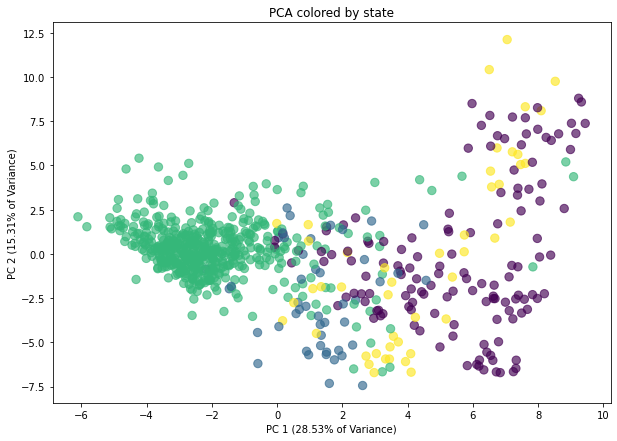

In [24]:
pca2, xpca2 = form_PCA(X_train)
plot_pca_cat(xpca2, pca2, cols, "PCA colored by state", cols = cols)

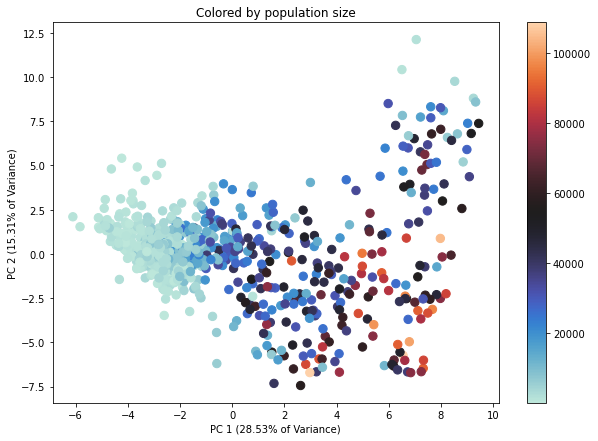

In [25]:
plot_pca(xpca2, pca2, X_train["Population"], "Colored by population size")

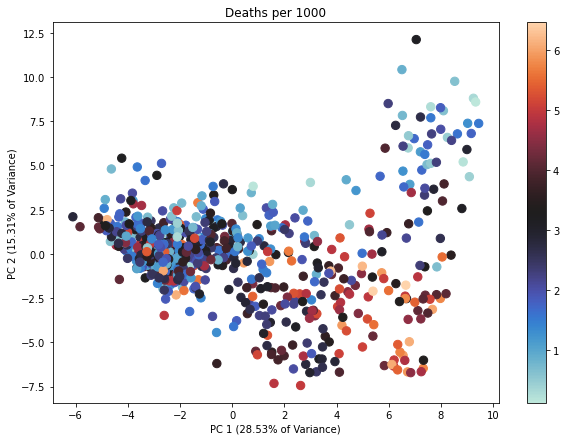

In [26]:
plot_pca(xpca2, pca2, y_train, "Deaths per 1000")

In [38]:
from random_forest import *
from optimize_rfr_hyperparams2 import *

def select_relevant(X):
    return(X.loc[:,"Median age":"North America(%)"])
X_train2, X_test2 = select_relevant(X_train), select_relevant(X_test)

In [42]:
#Random forest regression, zeroes removed, top 5% removed
rf_model = rfr_default(X_train2, y_train)

train_error = abs((rf_model.predict(X_train2)) - (y_train))
test_error = abs((rf_model.predict(X_test2)) - (y_test))

print(np.mean(train_error))
print(np.mean(test_error))


0.3152980549860382
0.8590609501954615


In [49]:
hyperparam_tuning = optimize_rf2(X_train2, y_train, random_grid = random_grid)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


In [50]:
hyperparam_tuning.best_params_

{'n_estimators': 400,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 68,
 'bootstrap': True}

In [52]:
params = hyperparam_tuning.best_params_
tuned_rf_model = rfr_custom(X_train2, y_train, params)

In [53]:
train_error = abs((tuned_rf_model.predict(X_train2)) - (y_train))
test_error = abs((tuned_rf_model.predict(X_test2)) - (y_test))

print(np.mean(train_error))
print(np.mean(test_error))

0.5428597570756597
0.8341947872040001


In [55]:
data = pd.read_csv("socio-demographic-and-death-counts(combined).csv")
data.head()

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Death Counts,Death Counts(Per 1000),Case Counts,Case Counts(Per 1000)
0,10001,25026,36.1,10.98,76.38,12.64,49.01,50.99,54.51,6.14,...,19.08,49.55,2.25,3.52,21.46,4.13,57,2.277631,7745,309.478143
1,10002,74363,44.8,13.09,63.18,23.74,49.29,50.71,22.16,7.77,...,5.55,79.01,0.61,1.27,12.85,0.70,412,5.540390,19171,257.802940
2,10003,54671,31.9,7.18,80.16,12.66,48.78,51.22,67.98,5.01,...,30.11,41.21,1.84,6.09,15.72,5.03,84,1.536464,13634,249.382671
3,10004,3310,38.4,7.37,84.23,8.40,47.34,52.66,66.89,4.50,...,27.89,53.26,2.97,7.42,2.08,6.38,2,0.604230,973,293.957704
4,10005,8664,30.4,10.20,88.73,1.06,47.68,52.32,70.16,2.01,...,36.36,41.91,0.72,9.01,8.49,3.52,1,0.115420,2323,268.120960


In [100]:

def trim_and_split(df, remove_0s = True, remove_outliers = True):
    if remove_0s:
        df = df[df.loc[:,"Death Counts(Per 1000)"] != 0]
    else:
        pass
    features = df.iloc[:,:-1]
    labels = df.iloc[:,-3]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)
    if remove_outliers:
        
        top5 = np.percentile(y_train, 95)
    
        X_train_95 = X_train[y_train <= top5]
        y_train_95 = y_train[y_train <= top5]

        X_test_95 = X_test[y_test <= top5]
        y_test_95 = y_test[y_test <= top5]
        
        print(top5)
        return X_train_95, X_test_95, y_train_95, y_test_95
    else:
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = trim_and_split(data, True, True)
y_train.head()

5.6801266852499985


328     1.751313
773     2.390200
949     5.104645
1805    5.086774
489     3.126954
Name: Death Counts(Per 1000), dtype: float64

In [62]:
from PCA_analysis import *
#cols=pltcolor(X_train.loc[:,"state"])
def form_PCA(df):
    Numeric_socdem = df.loc[:,"Median age":"North America(%)"]
    scaled_data = scale_df(Numeric_socdem)

    pca2, xpca2 = PCA_2(Numeric_socdem)

    return pca2, xpca2

In [77]:
pca2, xpca2 = form_PCA(X_train)
#plot_pca_cat(xpca2, pca2, cols, "PCA colored by state", cols = cols)

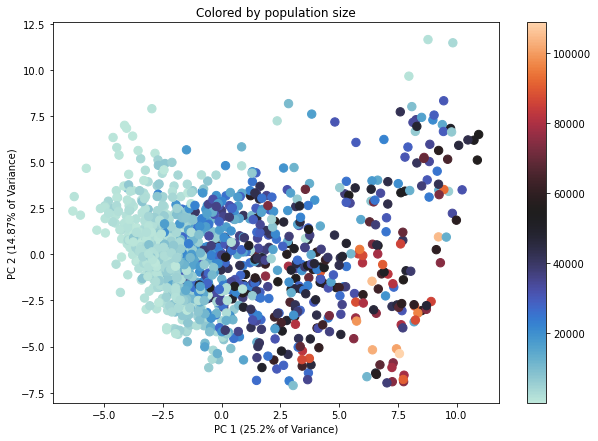

In [60]:
plot_pca(xpca2, pca2, X_train["Population"], "Colored by population size")

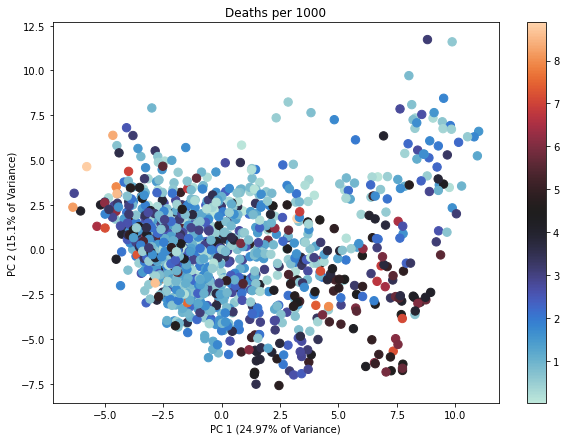

In [82]:
pca2, xpca2 = form_PCA(X_train)
plot_pca(xpca2, pca2, y_train, "Deaths per 1000")

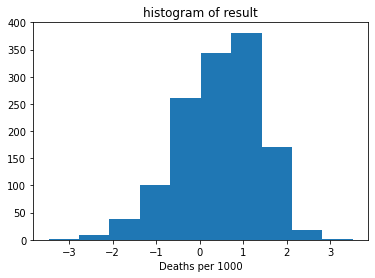

In [94]:
fig,ax = plt.subplots(1,1)

ax.hist(logtrain)
ax.set_title("histogram of result")
ax.set_xlabel("Deaths per 1000")
plt.show()

X_train_100, X_test_100, y_train_100, y_test_100 = trim_and_split(data, True, False)

X_train_100, X_test_100 = select_relevant(X_train_100), select_relevant(X_test_100)

logtrain = np.log(y_train_100)
logtest = np.log(y_test_100)

In [101]:
from random_forest import *
from optimize_rfr_hyperparams2 import *

def select_relevant(X):
    return(X.loc[:,"Median age":"North America(%)"])
X_train2, X_test2 = select_relevant(X_train), select_relevant(X_test)

In [102]:
#Random forest regression, zeroes removed, top 5% removed, all zips (updated May 5)
rf_model = rfr_default(X_train2, y_train)

train_error = abs((rf_model.predict(X_train2)) - (y_train))
test_error = abs((rf_model.predict(X_test2)) - (y_test))

print(np.mean(train_error))
print(np.mean(test_error))


0.28912482656880656
0.733942844001132


In [7]:
baseline_train_error = abs(np.median(y_train) - y_train)
baseline_test_error = abs(np.median(y_train) - y_test)

print(np.mean(baseline_train_error))
print(np.mean(baseline_test_error))

1.1824197283809585
1.1171352178912222


Text(0.5, 1.0, 'Covid-19 Related Deaths per 1000')

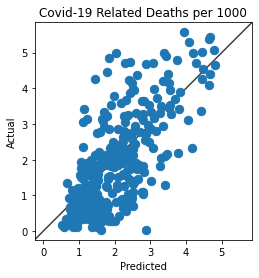

In [105]:
fig,ax = plt.subplots()
ax.scatter(x = (rf_model.predict(X_test2)), y = (y_test), s = 70)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Covid-19 Related Deaths per 1000")

In [ ]:
hyperparam_tuning = optimize_rf2(X_train2, y_train, random_grid = random_grid)

In [50]:
hyperparam_tuning.best_params_

{'n_estimators': 400,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 68,
 'bootstrap': True}

In [52]:
params = hyperparam_tuning.best_params_
tuned_rf_model = rfr_custom(X_train2, y_train, params)

In [53]:
train_error = abs((tuned_rf_model.predict(X_train2)) - (y_train))
test_error = abs((tuned_rf_model.predict(X_test2)) - (y_test))

print(np.mean(train_error))
print(np.mean(test_error))

0.5428597570756597
0.8341947872040001


In [97]:
#Random forest regression, zeroes removed, top 5% not removed, log-transformed
log_rf_model = rfr_default(X_train_100, logtrain)

train_error = abs(np.exp(log_rf_model.predict(X_train_100)) - np.exp(logtrain))
test_error = abs(np.exp(log_rf_model.predict(X_test_100)) - np.exp(logtest))

print(np.mean(train_error))
print(np.mean(test_error))



0.40855412498949517
0.8864230387691111
